# Prototype Model
---

* Regression
* 2009 data로 class1,2,3 10fold


https://docs.google.com/presentation/d/1cI3teBcQoGBhfrdVrv9rnM4jHGaPToDS7Zh7t0q7GKg/edit#slide=id.g97e66187c6_0_6

In [1]:
import tensorflow as tf

In [2]:
from random import seed as random_seed
random_seed(50)
from numpy.random import seed as np_random_seed
np_random_seed(50)

tf.random.set_seed(50)

In [3]:
import os

os.sys.path.append(r'/docker_mnt/data5/jin/jin/python/')

os.sys.path

['/sgcwhb/Malocclusion/bom_regression',
 '/root/miniconda3/lib/python37.zip',
 '/root/miniconda3/lib/python3.7',
 '/root/miniconda3/lib/python3.7/lib-dynload',
 '',
 '/root/miniconda3/lib/python3.7/site-packages',
 '/root/miniconda3/lib/python3.7/site-packages/IPython/extensions',
 '/root/.ipython',
 '/docker_mnt/data5/jin/jin/python/']

In [4]:
import tensorflow as tf
tf.__version__
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 740626635085362366,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11555299910455166892
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48242412749
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 7987356491072187716
 physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:b2:00.0, compute capability: 7.5",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11037241014281051995
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
%env PYTHONHASHSEED=0
from random import seed as random_seed
random_seed(42)
from numpy.random import seed as np_random_seed
np_random_seed(42)

import glob
import os
import pprint
from tqdm import tqdm

from IPython import display
import ipywidgets as widgets

# Data Science
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')

import cv2 as cv

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers, activations, initializers, regularizers, optimizers, losses, callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.nasnet import preprocess_input,NASNetLarge


env: PYTHONHASHSEED=0


## Paths
---

In [6]:
so_type = 'so_rl'
input_path_root = r'../data/input_data/'

loss_param=1
MODEL_TYPE="nasnet"

# <model 저장>
# output_path_root = r'../results/'
output_path_root = f'./results/{MODEL_TYPE}_multiout/5fold/transefer_v2_{loss_param}_{MODEL_TYPE}_rg_multiO3_so_img'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

try:
    os.makedirs(output_path_weight) 
    
except FileExistsError as err:      
    print(err)
# else:
#     print(output_path)

#     print(output_path_weight)

[Errno 17] File exists: './results/nasnet_multiout/5fold/transefer_v2_1_nasnet_rg_multiO3_so_img/so_rl/weights/'


In [7]:
input_path_root

'../data/input_data/'

In [8]:
output_path_root

'./results/nasnet_multiout/5fold/transefer_v2_1_nasnet_rg_multiO3_so_img'

## Data
---
- Class 0 : 분별하기 어려운 data (65 sample) -> 제외

- Class 3 : 하악이 상악보다 앞으로 돌출된 경우 (1136 sample) -> -1.0
- Class 1 : 상하악의 맞물림 상태는 정상이지만 치열이 고르지 않은 경우 (1707 sample) -> 0.0
- Class 2 : 상악이 하악보다 앞으로 돌출된 경우 (1175 sample) -> 1.0


In [9]:
def convert_label_class2reg(label_df):
    label_r = np.copy(label_df.angle_class_r)
    label_df.loc[label_r == 1, 'angle_class_r'] = 0
    label_df.loc[label_r == 2, 'angle_class_r'] = 1
    label_df.loc[label_r == 3, 'angle_class_r'] = -1
    
    label_l = np.copy(label_df.angle_class_l)
    label_df.loc[label_l == 1, 'angle_class_l'] = 0
    label_df.loc[label_l == 2, 'angle_class_l'] = 1
    label_df.loc[label_l == 3, 'angle_class_l'] = -1
    
    return label_df

def generate_data_by_patient(x, y, y_distance):
    if x.shape[-1] == 12:
        x = np.concatenate([x[..., :3], x[..., 3:6], x[..., 6:9], x[..., 9:]]) 
        y = np.concatenate([y[:, 0], y[:, 1], y[:, 2], y[:, 3]])
    elif x.shape[-1] == 6:
        x = np.concatenate([x[..., :3], x[..., 3:]]) # Right side,Left side !!!
        
        y_r_test= to_categorical(y[:,0], num_classes=3)
        y_l_test= to_categorical(y[:,1], num_classes=3)
        
        y = np.concatenate([y[:, 0], y[:, 1]])
        y_onehot=np.concatenate((y_r_test,y_l_test),axis=0)
        
        y_distance = np.concatenate([y_distance[:, 0], y_distance[:, 1]])
    
    return x, y, y_onehot, y_distance

# def generate_info_df_by_patient(info_df):
#     info_df_r = info_df.copy()
#     for row_idx, info in enumerate(info_df_r['info']):
#         info_df_r.iloc[row_idx] = info + '_r'
        
#     info_df_l = info_df.copy()
#     for row_idx, info in enumerate(info_df_l['info']):
#         info_df_l.iloc[row_idx] = info + '_l'
    
#     info_df = pd.concat((info_df_r, info_df_l), ignore_index=True)
#     del info_df_r, info_df_l
    
#     info_df1 = info_df.copy()
        
#     info_df2 = info_df.copy()
#     for row_idx, info in enumerate(info_df2['info']):
#         info_df2.iloc[row_idx] = info.replace('01A1', '02B1')
    
#     info_df = pd.concat((info_df1, info_df2), ignore_index=True)
#     del info_df1, info_df2

#     return info_df

In [10]:
x = np.load(os.path.join(input_path_root, f'data_KNU_Diorco_so_imgs.npy'))
label_df = pd.read_csv(os.path.join(input_path_root, f'data_Diorco_label.csv'))
label_df = convert_label_class2reg(label_df)

y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()

x = x.astype(np.float32)
y = y.astype(np.float32)
y_distance = y_distance.astype(np.float32)

print(x.max())
x=preprocess_input(x)
print(x.max())

#x = np.concatenate((x[::2, ...], x[1::2, ...]), axis=3)
#y = np.concatenate((y[::2, ...], y[1::2, ...]), axis=1)

255.0
1.0


In [11]:
pd.set_option('display.max_rows', None)

In [11]:
#---------onehot function test------------------
x_tt, y_tt, y_onehot_tt,y_distance_tt=generate_data_by_patient(x,y,y_distance)

y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]

y_onehot_tt_r=list(y_onehot_tt_r)
y_onehot_tt_l=list(y_onehot_tt_l)

label_df["one-hot-r"]=y_onehot_tt_r
label_df["one-hot-l"]=y_onehot_tt_l

print("regression:",y_tt.min(),"||",y_tt.max())
print("classification:",y_onehot_tt.min(),"||",y_onehot_tt.max())
print("distance:",y_distance_tt.min(),"||",y_distance_tt.max())

label_df

#---------------------------------------------

regression: -1.0 || 1.0
classification: 0.0 || 1.0
distance: -24.48 || 25.12


,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


float32 (2009, 480, 784, 6)
float32 (2009, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2009 entries, 0 to 2008
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_id     2009 non-null   object 
 1   tx_phase       2009 non-null   object 
 2   angle_class_r  2009 non-null   int64  
 3   angle_class_l  2009 non-null   int64  
 4   distance(r)    2009 non-null   float64
 5   distance(l)    2009 non-null   float64
 6   one-hot-r      2009 non-null   object 
 7   one-hot-l      2009 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 125.7+ KB


None

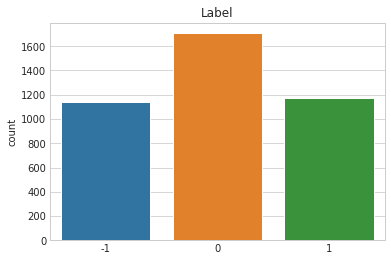

In [12]:
print(x.dtype, x.shape)
print(y.dtype, y.shape)
print()
display.display(label_df.info())
# display.display(label_df)

plt.style.use('seaborn-whitegrid')
plt.figure()

plt.title('Label')
sns.countplot(np.concatenate([label_df.angle_class_r, label_df.angle_class_l]))

plt.show()
plt.style.use('seaborn-white')

In [13]:
cnt = np.concatenate([label_df.angle_class_r, label_df.angle_class_l])


print("calss -1:",len(cnt[cnt==-1]))
print("calss 0:",len(cnt[cnt==0]))
print("calss 1:",len(cnt[cnt==1]))

calss -1: 1136
calss 0: 1707
calss 1: 1175


## Model
---

In [14]:
def build_model():
    base_model = NASNetLarge(include_top=False, weights="imagenet", input_shape=(331, 331, 3))    
    
    base_model.trainable=False
    
    x = base_model.output

    x = layers.GlobalAveragePooling2D(name='gap')(x)
    x = layers.Dense(1024, activation='relu', name='dense_1')(x)
    x = layers.Dropout(0.2, name='dropout_1')(x)
    x = layers.Dense(256, activation='relu', name='dense_2')(x)
    x = layers.Dropout(0.2, name='dropout_2')(x)
    x = layers.Dense(32, activation='relu', name='dense_3')(x)
    x = layers.Dropout(0.2, name='dropout_3')(x)

    
    regression_prediction=layers.Dense(1, name='regression_prediction')(x)
    one_hot_prediction=layers.Dense(3, activation='softmax', name='classification')(regression_prediction)
    distance_prediction=layers.Dense(1, name='distance_prediction')(x)

    
    model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
#     model = models.Model(inputs=base_model.input, outputs=[regression_prediction,one_hot_prediction,distance_prediction])
    
    return model

In [16]:
model=build_model()

In [17]:
# model.compile(optimizer=optimizers.Adam(lr=1e-3),
#                       loss=["mae","categorical_crossentropy","mae"],
#                       metrics=["acc","mae"])
model.compile(optimizer=optimizers.Adam(lr=0.001),
              loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
              loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':loss_param},
              metrics={'regression_prediction':"mae",'classification':"acc",'distance_prediction':"mae"})

In [18]:
model.summary(line_length=200)

Model: "model"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                      Output Shape                                Param #                 Connected to                                                      
input_1 (InputLayer)                                              [(None, 331, 331, 3)]                       0                                                                                         
________________________________________________________________________________________________________________________________________________________________________________________________________
stem_conv1 (Conv2D)                                               (None, 165, 165, 96)                        2592                    input_1[0][0]                                  

## Train the Model
---

In [15]:
def to331_resize(data_set):
    data=np.empty((data_set.shape[0],331,331,3))
    
    for i in range(data.shape[0]):
        data[i]=cv.resize(data_set[i], dsize=(331, 331), interpolation=cv.INTER_AREA)
#         print(i)
        
    return data

In [20]:
def scheduler(epoch, lr):
    if epoch < 40:
        return lr
    else:
        return lr * tf.math.exp(+0.1)

In [26]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])): #left???

    if kfold_idx >= 4:
        display.clear_output(wait=True)
        print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

        # 1. Data
        # ----------------------------------------

    #------DEBUG--------:
    #     print(test_idxs)     
    #     print(np.unique(y[test_idxs, 0], return_counts=True))
    #-------------------   

        x_train = x[train_idxs]
        y_train = y[train_idxs]
        y_distance_train =y_distance[train_idxs]
    #     label_df_train = label_df.iloc[train_idxs]

        x_train, x_val, y_train, y_val, y_distance_train, y_distance_val = train_test_split(x_train, y_train, y_distance_train, test_size=0.2, 
                                                                                        random_state=42, stratify=y_train[:, 0])

        x_test = x[test_idxs]
        y_test = y[test_idxs]
        y_distance_test =y_distance[test_idxs]
    #     label_df_test = label_df.iloc[test_idxs]

        #distance 누락!
        x_train, y_train,y_train_onehot, y_train_distance = generate_data_by_patient(x_train, y_train, y_distance_train)
        x_val, y_val, y_val_onehot, y_val_distance = generate_data_by_patient(x_val, y_val, y_distance_val)
        x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test, y_distance_test)

        x_train=to331_resize(x_train)
        x_val=to331_resize(x_val)
        x_test=to331_resize(x_test)


        weight_for_m1 = (1 / len(y_train[y_train==-1]))*(len(y_train))/3.0 
        weight_for_0 = (1 / len(y_train[y_train==0]))*(len(y_train))/3.0 
        weight_for_1 = (1 / len(y_train[y_train==1]))*(len(y_train))/3.0

        class_weight=[weight_for_m1,weight_for_0,weight_for_1]

        # 2. Paths
        # ----------------------------------------

        output_path_kfold = os.path.join(output_path, f'kfold_{kfold_idx + 1:02d}/')
        output_path_weight = os.path.join(output_path_kfold, r'weights/')

        if os.path.isdir(output_path_weight)==False:
            os.makedirs(output_path_weight)


        if kfold_idx==21:
            model = build_model()
            
            model.compile(optimizer=optimizers.SGD(lr=0.01),
                          loss={'regression_prediction':"mae",'classification':"categorical_crossentropy",'distance_prediction':"mae"},
                          loss_weights={'regression_prediction':1,'classification':1,'distance_prediction':loss_param},
                          metrics={'regression_prediction':"mae",'classification':"acc",'distance_prediction':"mae"})
        
            model.save(os.path.join(output_path, r'model.hdf5'))
        

        else:
            model = models.load_model(os.path.join(output_path, r'model.hdf5'))

        initial_epochs=0    
        if initial_epochs != 0:
            model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{ initial_epochs :08d}*.hdf5'))[0])

#         print(model.trainable_weights)

        # 4. Train the Model.
        # ----------------------------------------

        # Callbacks
        checkpointer = callbacks.ModelCheckpoint(os.path.join(output_path_weight, 'weights_{epoch:08d}_{val_loss:.4g}.hdf5'),
                                                 save_weights_only=True)
        csv_logger = callbacks.CSVLogger(os.path.join(output_path_kfold, r'log.csv'), append=True)
        learning_sch = callbacks.LearningRateScheduler(scheduler)

        # Training batch size 16 -> 8
        model.fit(x_train,{'regression_prediction':y_train, 'classification':y_train_onehot,'distance_prediction':y_train_distance},
                  batch_size=128,
                  epochs=100,
                  validation_data=(x_val, {'regression_prediction':y_val,'classification':y_val_onehot,'distance_prediction':y_val_distance}),
                  callbacks=[checkpointer, csv_logger],
                  initial_epoch=initial_epochs,
                  class_weight={'regression_prediction':class_weight,'classification':class_weight,'distance_prediction':class_weight},
                  verbose=1)

        K.clear_session()
        del model
    


K-Fold CV: 05/05
Train on 2572 samples, validate on 644 samples
Epoch 1/100
2572/2572 [==============================] - 56s 22ms/sample - loss: 3.8363 - regression_prediction_loss: 0.6504 - classification_loss: 1.1061 - distance_prediction_loss: 2.0443 - regression_prediction_mae: 0.6525 - classification_acc: 0.2967 - distance_prediction_mae: 2.0766 - val_loss: 3.8008 - val_regression_prediction_loss: 0.6299 - val_classification_loss: 1.0939 - val_distance_prediction_loss: 2.3892 - val_regression_prediction_mae: 0.6030 - val_classification_acc: 0.3773 - val_distance_prediction_mae: 2.1079
Epoch 2/100
2572/2572 [==============================] - 38s 15ms/sample - loss: 3.7498 - regression_prediction_loss: 0.6306 - classification_loss: 1.0909 - distance_prediction_loss: 2.0563 - regression_prediction_mae: 0.6285 - classification_acc: 0.3585 - distance_prediction_mae: 2.0288 - val_loss: 3.8060 - val_regression_prediction_loss: 0.6412 - val_classification_loss: 1.0993 - val_distance_predi

In [ ]:
safdsgf

In [ ]:
y_train.shape

In [ ]:
y_train_onehot.shape

## Evaluation
---

In [16]:
info_df = label_df.copy()
info_df

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
1,QH0026,Post-Tx,0,1,1.22,2.10,"[1.0, 0.0, 0.0]","[0.0, 1.0, 0.0]"
2,QH0041,Pre-Tx,1,0,2.57,0.88,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
4,QH0044,Pre-Tx,1,1,6.94,4.63,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...
2004,QH1058,Post-Tx,0,0,2.00,1.00,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
2005,QH1072,Pre-Tx,-1,-1,-4.99,-2.83,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]"
2006,QH1072,Post-Tx,1,1,7.41,5.26,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
2007,QH1084,Pre-Tx,0,-1,-0.55,-0.55,"[1.0, 0.0, 0.0]","[0.0, 0.0, 1.0]"


In [17]:
info_df.iloc[[0,3,5,6,7]]

,patient_id,tx_phase,angle_class_r,angle_class_l,distance(r),distance(l),one-hot-r,one-hot-l
0,QH0026,Pre-Tx,0,0,1.48,1.23,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
3,QH0041,Post-Tx,1,0,3.58,1.05,"[0.0, 1.0, 0.0]","[1.0, 0.0, 0.0]"
5,QH0044,Post-Tx,1,1,9.15,7.06,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]"
6,QH0059,Pre-Tx,0,0,1.13,0.81,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]"
7,QH0059,Post-Tx,1,-1,1.53,0.49,"[0.0, 1.0, 0.0]","[0.0, 0.0, 1.0]"


0
K-Fold CV: 01/05
[   4    6   28   31   33   38   42   44   46   49   50   51   64   65
   68   71   72   73   74   80   93   94   96   98  121  122  129  150
  153  158  165  167  175  196  201  220  221  234  236  237  242  245
  247  250  251  256  267  269  276  277  278  283  286  290  291  294
  304  308  310  313  319  322  328  331  333  338  342  344  347  349
  350  353  357  364  372  376  380  402  404  414  418  421  422  431
  435  444  445  458  464  469  475  478  482  485  492  494  499  505
  519  523  528  536  549  557  558  562  563  564  567  575  576  579
  580  584  585  593  601  603  605  609  611  617  625  631  634  644
  656  658  661  662  666  667  671  672  674  695  702  703  705  710
  711  715  720  721  724  726  729  731  734  736  738  746  750  752
  753  754  758  759  765  770  783  802  803  804  807  820  838  842
  846  847  848  853  861  866  869  874  875  878  881  890  895  900
  903  904  905  909  919  920  924  930  932  939  943  9

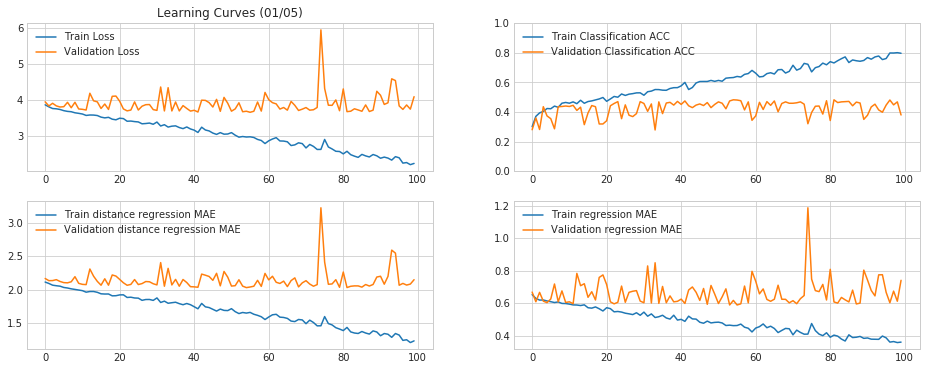

Min. validation loss epoch: 56
Max. Classification ACC epoch: 55
Max. Classification ACC: 0.48291925
Min. distance regression validation MAE epoch: 55
Min. regression validation MAE epoch: 56
1
K-Fold CV: 02/05
[   5    7   11   13   29   35   41   52   56   57   60   63   66   70
   88   89   91   92   97   99  100  103  104  106  109  117  125  130
  135  141  142  147  157  159  163  170  174  177  178  180  182  185
  189  191  197  199  203  212  219  228  233  257  259  268  271  275
  280  282  284  296  299  303  306  311  312  314  320  321  325  330
  336  345  352  358  359  360  362  365  377  381  389  391  395  405
  411  420  427  432  436  439  440  442  443  449  455  459  471  473
  477  480  481  483  486  489  495  497  512  518  520  524  529  534
  541  551  555  556  565  566  569  570  578  588  591  596  597  602
  604  607  614  620  627  632  641  645  651  652  668  673  675  676
  681  685  687  692  696  698  700  707  716  730  732  733  737  761
  776  7

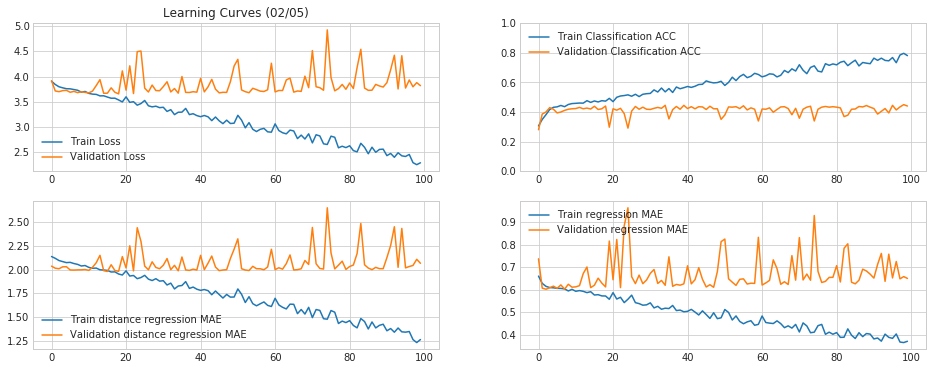

Min. validation loss epoch: 19
Max. Classification ACC epoch: 99
Max. Classification ACC: 0.45031056
Min. distance regression validation MAE epoch: 16
Min. regression validation MAE epoch: 3
2
K-Fold CV: 03/05
[   0    1   10   15   18   22   26   30   36   43   45   48   55   61
   62   67   77   78   82   85  107  110  111  114  116  118  119  126
  131  136  137  140  143  144  146  148  154  156  160  166  171  173
  179  181  188  193  195  200  202  208  225  226  231  232  246  249
  252  272  274  279  289  292  295  297  305  309  317  318  323  326
  327  329  332  335  341  343  354  356  363  368  369  373  374  379
  384  396  399  400  403  407  408  409  410  417  424  426  428  434
  437  446  447  456  468  470  488  500  507  509  510  511  514  516
  517  521  527  530  531  532  539  540  543  548  552  560  568  574
  577  583  586  599  606  608  612  615  623  629  630  639  640  647
  654  657  659  663  670  682  684  686  690  693  694  706  728  739
  742  74

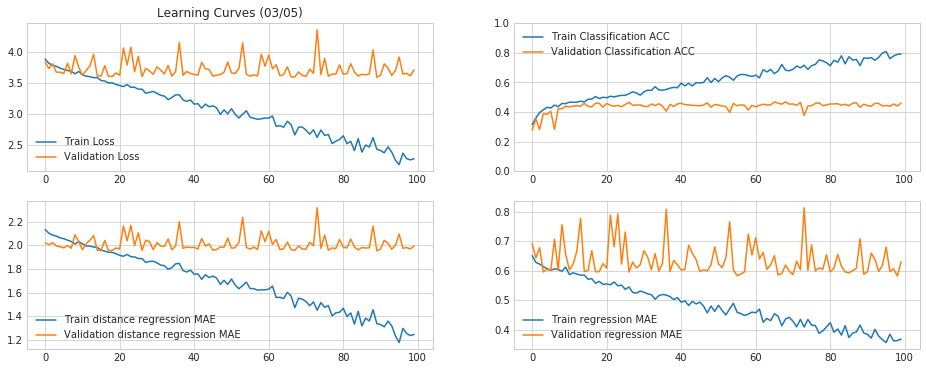

Min. validation loss epoch: 90
Max. Classification ACC epoch: 66
Max. Classification ACC: 0.4689441
Min. distance regression validation MAE epoch: 90
Min. regression validation MAE epoch: 99
3
K-Fold CV: 04/05
[   9   12   16   19   20   23   25   32   34   40   54   58   59   69
   76   83   84   87   90  105  124  127  133  134  149  155  161  162
  168  169  184  186  187  192  204  206  209  211  213  214  218  238
  239  240  243  244  253  255  258  262  265  273  281  285  288  293
  298  301  302  307  316  324  334  337  339  355  366  370  371  375
  378  382  386  387  392  393  394  401  415  419  425  429  438  451
  453  454  457  462  465  472  479  484  487  490  498  502  503  504
  506  508  513  526  533  535  544  545  559  587  589  590  594  595
  610  613  618  621  626  633  635  636  637  638  642  643  650  653
  655  660  664  669  680  683  688  689  697  699  701  704  709  714
  717  722  725  727  745  749  751  756  763  768  769  771  773  775
  777  79

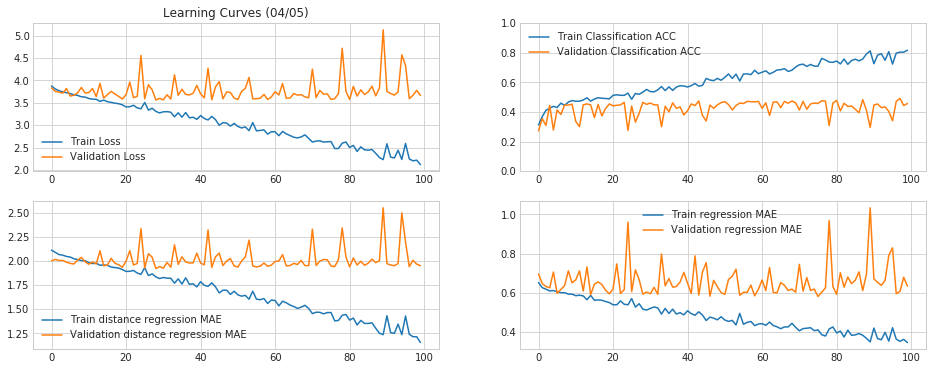

Min. validation loss epoch: 29
Max. Classification ACC epoch: 98
Max. Classification ACC: 0.49223602
Min. distance regression validation MAE epoch: 29
Min. regression validation MAE epoch: 76
4
K-Fold CV: 05/05
[   2    3    8   14   17   21   24   27   37   39   47   53   75   79
   81   86   95  101  102  108  112  113  115  120  123  128  132  138
  139  145  151  152  164  172  176  183  190  194  198  205  207  210
  215  216  217  222  223  224  227  229  230  235  241  248  254  260
  261  263  264  266  270  287  300  315  340  346  348  351  361  367
  383  385  388  390  397  398  406  412  413  416  423  430  433  441
  448  450  452  460  461  463  466  467  474  476  491  493  496  501
  515  522  525  537  538  542  546  547  550  553  554  561  571  572
  573  581  582  592  598  600  616  619  622  624  628  646  648  649
  665  677  678  679  691  708  712  713  718  719  723  735  740  741
  743  744  748  760  762  764  766  767  774  778  782  787  788  789
  801  8

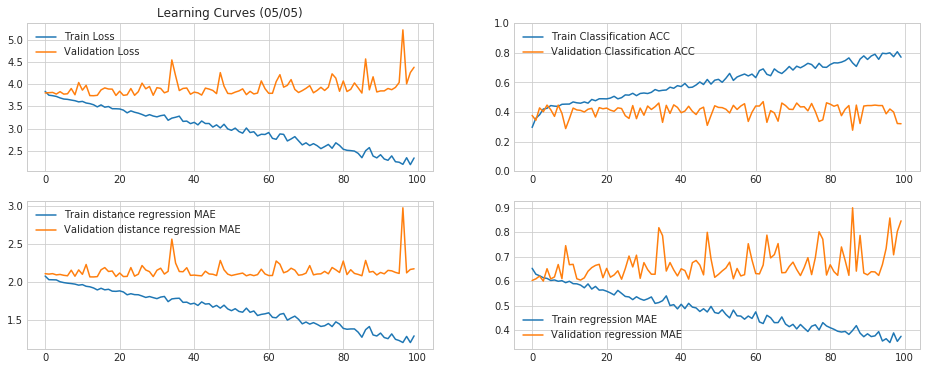

Min. validation loss epoch: 14
Max. Classification ACC epoch: 63
Max. Classification ACC: 0.4704969
Min. distance regression validation MAE epoch: 14
Min. regression validation MAE epoch: 4


In [21]:
metrics = []
predictions_kfold = []
labels_kfold = []
distance_regression = [] 

total_info =[]
total_info_2 =[]

fold_testidx=[]
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# model_parm_name="D"+depth+"_"+dropout_rat

for kfold_idx, (train_idxs, test_idxs) in enumerate(kfold.split(x, y[:, 0])):
    
    print(kfold_idx)
    
    print(f'K-Fold CV: {kfold_idx + 1:02d}/{kfold.n_splits:02d}')

    print(test_idxs)
    fold_testidx.append(test_idxs)
    # 1. Data
    # ----------------------------------------
    x_test = x[test_idxs]
    y_test = y[test_idxs]
    y_test_distance= y_distance[test_idxs]

    label_df_test = label_df.iloc[test_idxs]

    x_test, y_test, y_test_onehot, y_test_distance = generate_data_by_patient(x_test, y_test,y_test_distance)
    
    x_test=to331_resize(x_test)

    # 2. Paths
    # ----------------------------------------

#     output_path_kfold = os.path.join(output_path, model_parm_name, f'kfold_{kfold_idx + 1:02d}/')
    output_path_kfold = os.path.join(output_path,  f'kfold_{kfold_idx + 1:02d}/')
    output_path_weight = os.path.join(output_path_kfold, r'weights/')

    # 3. Plot Learning Curves.
    # ----------------------------------------

    # log 저장: loss, mae, val_loss, val_mae
    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))


    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(16, 6))

    plt.subplot(2,2,1)
    plt.title(f'Learning Curves ({kfold_idx + 1:02d}/{kfold.n_splits:02d})')
    plt.plot(log_df.loss)
    plt.plot(log_df.val_loss)
    plt.legend(('Train Loss', 'Validation Loss'))

    plt.subplot(2,2,2)
    plt.plot(log_df.classification_acc)
    plt.plot(log_df.val_classification_acc)
    plt.ylim(0, 1)
    plt.legend(('Train Classification ACC', 'Validation Classification ACC'))

    plt.subplot(2,2,3)
    plt.plot(log_df.distance_prediction_mae)
    plt.plot(log_df.val_distance_prediction_mae)
    plt.legend(('Train distance regression MAE', 'Validation distance regression MAE'))

    plt.subplot(2,2,4)
    plt.plot(log_df.regression_prediction_mae)
    plt.plot(log_df.val_regression_prediction_mae)
    plt.legend(('Train regression MAE', 'Validation regression MAE'))

    plt.show()
    plt.style.use('seaborn-white')
    print(f'Min. validation loss epoch: {log_df.val_loss.idxmin() + 1}')
    print(f'Max. Classification ACC epoch: {log_df.val_classification_acc.idxmax() + 1}')
    print(f'Max. Classification ACC: {log_df.val_classification_acc[log_df.val_classification_acc.idxmax()]}')
    print(f'Min. distance regression validation MAE epoch: {log_df.val_distance_prediction_mae.idxmin() + 1}')
    print(f'Min. regression validation MAE epoch: {log_df.val_regression_prediction_mae.idxmin() + 1}')



    info_df = label_df.copy()

    result_info_df = info_df.iloc[test_idxs]

    inference_df = result_info_df.copy()
    inference_df2 = result_info_df.copy()

    # 4. Load a Model.
    # ----------------------------------------

#         K.clear_session()

    #sgcwhb/Malocclusion/results/prototype_regression_so_img/so_rl/model.hdf5
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    model2 = models.load_model(os.path.join(output_path, r'model.hdf5'))
    #validation mae가 가장 적은 model weight load
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_regression_prediction_mae.idxmin()+1:08d}*.hdf5'))[0])
    model2.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_classification_acc.idxmax()+1:08d}*.hdf5'))[0])
    # 5. Display
    # ----------------------------------------


    prediction = model.predict(x_test)
    prediction2 = model2.predict(x_test)

    prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
    prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left

    prediction_class_r = prediction2[1][:int(prediction[1].shape[0]/2)] #Right
    prediction_class_l = prediction2[1][int(prediction[1].shape[0]/2):] #left

    r = prediction_distance_r.copy()
    l = prediction_distance_l.copy()

    r2 = prediction_class_r.copy()
    l2 = prediction_class_l.copy()

    #-1~1사이 score
    r = np.round(r) #반올림
    r[r<-1]= -1
    r[r>1] = 1


    l = np.round(l)
    l[l<-1]= -1
    l[l>1] = 1  

    # onehot value score
    r2 = np.round(r2) #반올림
    r2= r2.tolist()
    r2_2=[]
    for xx in r2:
        if xx==[0.0,0.0,1.0]:
            xx=-1
        elif xx==[1.0,0.0,0.0]:
            xx=0
        else:
            xx=1
        r2_2.append(xx)

    l2 = np.round(l2)
    l2= l2.tolist()
    l2_2=[]
    for xy in l2:
        if xy==[0.0,0.0,1.0]:
            xy=-1
        elif xy==[1.0,0.0,0.0]:
            xy=0
        else:
            xy=1
        l2_2.append(xy)
#     print(l.shape)
#     print(r.shape)
#     print(info_df.shape)
#     print(result_info_df.shape)

    inference_df['prediction_class_r'] = r
    inference_df['prediction_class_l'] =l
    inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
    inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)

    inference_df2['prediction_class_r']=r2_2
    inference_df2['prediction_class_l']=l2_2
    inference_df2['prediction_onehot_class_r']=r2
    inference_df2['prediction_onehot_class_l']=l2


    inference_df.to_csv(os.path.join(output_path_kfold, r'info_v1_2.csv')) # log_df.val_regression_prediction_mae.idxmin()
    inference_df2.to_csv(os.path.join(output_path_kfold, r'info_v2_2.csv')) # log_df.val_classification_acc.idxmax()

    total_info.append(inference_df)
    total_info_2.append(inference_df2)

total_df = pd.concat(total_info)
total_df.to_csv(os.path.join(output_path,'total_v1_2.csv'))

total_df2 = pd.concat(total_info_2)
total_df2.to_csv(os.path.join(output_path,'total_v2_2.csv'))

In [ ]:
total_df

In [ ]:
total_df2

In [ ]:
kfold_results_df = pd.DataFrame(metrics, columns=('test_loss', 'test_mae'))


In [ ]:
data = total_df['angle_class_r'].append(total_df['angle_class_l'])
prediction =  total_df['prediction_class_r'].append(total_df['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

In [ ]:
total_df=pd.read_csv(os.path.join(output_path,'total_v2_2.csv'))

In [ ]:
data = total_df2['angle_class_r'].append(total_df2['angle_class_l'])
prediction =  total_df2['prediction_class_r'].append(total_df2['prediction_class_l'])
data = np.array(data)
prediction=np.array(prediction,dtype = int)

cm = confusion_matrix(data, prediction, labels=[-1, 0, 1])

print(cm)
print("")
print(f'Accuracy: {(cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum():.3f}')

In [ ]:
np.sum(cm)

# inference

In [ ]:
output_path_root = f'../../results/{MODEL_TYPE}_multiout/5fold/v1_{loss_param}_{MODEL_TYPE}_rg_multiO3_so_img'
output_path = os.path.join(output_path_root,  so_type)
output_path_weight = os.path.join(output_path, r'weights/')

In [ ]:
def data_preprocess(x,label):
    label_df = convert_label_class2reg(label)
    
    y = label_df.loc[:, ['angle_class_r', 'angle_class_l']].to_numpy()
    y_distance= label_df.loc[:, ['distance(r)', 'distance(l)']].to_numpy()
    y = y.astype(np.float32)
    y_distance = y_distance.astype(np.float32)
    
    x = data.astype(np.float32)
    x=preprocess_input(x)    
    
    return x, y, y_distance

def one_hot_df(y_test_onehot):

    y_onehot_tt_r=y_onehot_tt[:(y_onehot_tt.shape[0]//2)]
    y_onehot_tt_l=y_onehot_tt[(y_onehot_tt.shape[0]//2):]
    
    y_onehot_tt_r=list(y_onehot_tt_r)
    y_onehot_tt_l=list(y_onehot_tt_l)
    
    label_df["one-hot-r"]=y_onehot_tt_r
    label_df["one-hot-l"]=y_onehot_tt_l
    
    return label_df

def regression_predict(prediction):
    prediction_distance_r = prediction[0][:int(prediction[0].shape[0]/2),0] #Right
    prediction_distance_l = prediction[0][int(prediction[0].shape[0]/2):,0] #left
    
    r = prediction_distance_r.copy()
    l = prediction_distance_l.copy()

    #-1~1사이 score
    r = np.round(r) #반올림
    r[r<-1]= -1
    r[r>1] = 1

    l = np.round(l)
    l[l<-1]= -1
    l[l>1] = 1      

    return prediction_distance_r, prediction_distance_l, int(r),int(l)
    
    
def one_hot_predict(prediction):
    prediction_class_r = prediction2[1][:int(prediction[1].shape[0]/2)] #Right
    prediction_class_l = prediction2[1][int(prediction[1].shape[0]/2):] #left

    r = prediction_class_r.copy()
    l = prediction_class_l.copy()    

    # onehot value score
    r = np.round(r) #반올림
    r= r.tolist()
    r2=[]
    for xx in r:
        if xx==[0.0,0.0,1.0]:
            xx=-1
        elif xx==[1.0,0.0,0.0]:
            xx=0
        else:
            xx=1
        r2.append(xx)

    l = np.round(l)
    l= l.tolist()
    l2=[]
    for xy in l:
        if xy==[0.0,0.0,1.0]:
            xy=-1
        elif xy==[1.0,0.0,0.0]:
            xy=0
        else:
            xy=1
        l2.append(xy)
        
    return r, l, r2, l2
        
    
def inference(data,label_df):
    
    #---------root_path---------
    MODEL_TYPE="nasnet"
    loss_param=0.5
    kfold=1
    output_path_root = f'../../results/{MODEL_TYPE}_multiout/5fold/v1_{loss_param}_{MODEL_TYPE}_rg_multiO3_so_img'
    output_path = os.path.join(output_path_root,  "so_rl", f'kfold_{kfold + 1:02d}/')
    output_path_weight= os.path.join(output_path_kfold, r'weights/')
    #---------------------------
    
    #-----------data------------
    #---------------------------
    x, y, y_distance = data_preprocess(data,label_df)
    x_tt, y_test, y_test_onehot, y_test_distance=generate_data_by_patient(x,y,y_distance)
    
    x_test=to331_resize(x_tt)
    label_df_test=one_hot_df(y_test_onehot)
    #---------------------------
    
    
    inference_df = label_df_test.copy()

    log_df = pd.read_csv(os.path.join(output_path_kfold, r'log.csv'))
    model = models.load_model(os.path.join(output_path, r'model.hdf5'))
    model2 = models.load_model(os.path.join(output_path, r'model.hdf5'))
    
    model.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_regression_prediction_mae.idxmin() + 1:08d}*.hdf5'))[0])
    model2.load_weights(glob.glob(os.path.join(output_path_weight, f'weights_{log_df.val_classification_acc.idxmax() + 1:08d}*.hdf5'))[0])

    prediction = model.predict(x_test)
    prediction2 = model2.predict(x_test)

    prediction_distance_r, prediction_distance_l, r, l=regression_predict(prediction)
    prediction_class_r, prediction_class_l, r2, l2=regression_predict(prediction2)


    inference_df['regression_prediction_class_r'] = r
    inference_df['regression_prediction_class_l'] = l
    inference_df['regression_distance_r'] = np.round(prediction_distance_r,3)
    inference_df['regression_distance_l'] = np.round(prediction_distance_l,3)
    inference_df['onehot_prediction_class_r']=r2
    inference_df['onehot_prediction_class_l']=l2
    inference_df['onehot_class_r']=prediction_class_r
    inference_df['onehot_class_l']=prediction_class_l


    inference_df.to_csv(os.path.join(output_path, r'inference.csv'))
    total_info.append(inference_df)

    total_df = pd.concat(total_info)
    total_df.to_csv(os.path.join(output_path,'total_inference.csv'))
    
    for i in range(x.shape[0]):
        fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(20, 10))
        ax1.set_title(f"S{i:04d}_right_class:{total_df['angle_class_r'][i]}",fontsize=16)
        right = x[i,...,:3]
        ax1.imshow(right,cmap='Greys_r',vmin=right.min(),vmax=right.max())

        ax2.set_title(f"S{i:04d}_left_class:{total_df['angle_class_l'][i]}",fontsize=16)
        left = x[i,...,3:]
        ax2.imshow(left,cmap='Greys_r',vmin=right.min(),vmax=right.max())
    
        print("regression model predict",\n,f"right:{inference_df['regression_prediction_class_r'][i]}||left:{inference_df['regression_prediction_class_l'][i]}")
        print("onehot model predict",\n,f"right:{inference_df['onehot_prediction_class_r'][i]}||left:{inference_df['onehot_prediction_class_l'][i]}")
    
    return inference_df
    